# 0.0. Imports

In [920]:
import pandas as pd
import numpy as np
import inflection
import holidays
import requests
import pickle
import math
from IPython.core.display  import HTML

from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

## 0.1. Helper Functions

In [557]:
def plot_segment(x,y,data):
    sns.scatterplot(x=x, y=y, hue='segment', data=data, size='segment', sizes=(50,250), size_order=['VIP', 'Premium','Master','Business', 'Inactive'])
    plt.title('Customers Segment')
    plt.show()

def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    
    return df_final

def calculate_optimal_cluster(wcss):
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distancias = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerador = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominador = math.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distancias.append(numerador/denominador)
    
    return distancias.index(max(distancias)) + 2

def calculate_wcss(data):
    wcss = []
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(X=data)
        wcss.append(kmeans.inertia_)
    return wcss


def plot_perc(st,dados, order=False, rotation=False):
    plt.figure(figsize=(20,8))

    if order == True:
        g = sns.countplot(x=st, data=dados, orient='h', order = dados[st].value_counts().index)
    else:
        g = sns.countplot(x=st, data=dados, orient='h')
    g.set_xlabel(st, fontsize=17)
    g.set_ylabel("count", fontsize=17)
    if rotation == True:
        g.set_xticklabels(g.get_xticklabels(),rotation=90)
    else:
        g.set_xticklabels(g.get_xticklabels())
    sizes = []
    for p in g.patches:
        height = p.get_height()
        sizes.append(height)
        g.text(p.get_x()+p.get_width()/1.6,
            height + 200,
            '{:1.2f}%'.format(height/dados.shape[0]*100),
            ha="center", va='bottom',fontsize=9) 
    g.set_ylim(0, max(sizes) * 1.1)

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    warnings.simplefilter(action='ignore')
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    pd.pandas.set_option('display.max_columns', None)
    pd.pandas.set_option('display.max_rows', None)
    pd.pandas.set_option('display.expand_frame_repr', False)
    
    sns.set()

In [267]:
# Run jupyter settings
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

In [4]:
df_data_raw = pd.read_csv('data/OnlineRetail.csv', encoding="ISO-8859-1")

df_data_raw.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
360455,568228,22960,JAM MAKING SET WITH JARS,6,26-09-2011 11:02,4.25,15358.0,United Kingdom
272249,560772,21467,CHERRY CROCHET FOOD COVER,3,20-07-2011 16:12,3.29,NaN,United Kingdom
501981,578833,23167,SMALL CERAMIC TOP STORAGE JAR,1,25-11-2011 15:23,1.63,NaN,United Kingdom
66010,541711,22331,WOODLAND PARTY BAG + STICKER SET,96,21-01-2011 11:18,1.45,14646.0,Netherlands
78274,542862,21671,RED SPOT CERAMIC DRAWER KNOB,1,01-02-2011 11:51,1.25,14606.0,United Kingdom


# 1.0. Data Description

In [181]:
df1 = df_data_raw.copy()

## 1.1. Rename Columns

In [182]:
# CamelCase to snake_case
cols_old = df1.columns.to_list()

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

## 1.2. Data Dimensions

In [183]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 541909
Number of Columns: 8


## 1.3. Data Types

In [184]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check Duplicates

In [185]:
df1.duplicated().sum()

5268

## 1.5. Manage Duplicates

In [186]:
# Let's remove the duplicated data
df1 = df1.drop_duplicates()

## 1.6. Check NA

In [187]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135037
country              0
dtype: int64

## 1.7. Manage NA

In [188]:
# We will only drop the NA values since the we can't fillout the features that have NA values.
df1 = df1.dropna()

assert df1.isna().sum().sum() == 0

## 1.8. Change Data Types

In [189]:
# analyse date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'])

assert df1['invoice_date'].dtype == "datetime64[ns]"

In [190]:
# analyse invoice_no column
df1['invoice_no'].str.isnumeric().value_counts()

True     392732
False      8872
Name: invoice_no, dtype: int64

In [191]:
df1['invoice_no'].loc[df1['invoice_no'].str.isnumeric() == False].value_counts().head()

C570867    101
C560540     57
C548460     45
C560855     40
C570828     39
Name: invoice_no, dtype: int64

In [192]:
# We can see negative values in the quantity column
df1[df1['invoice_no'] == "C570867"].head(3)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
393995,C570867,23290,SPACEBOY CHILDRENS BOWL,-8,2011-12-10 16:17:00,1.25,12607.0,USA
393996,C570867,23289,DOLLY GIRL CHILDRENS BOWL,-8,2011-12-10 16:17:00,1.25,12607.0,USA
393997,C570867,23256,CHILDRENS CUTLERY SPACEBOY,-4,2011-12-10 16:17:00,4.15,12607.0,USA


In [193]:
# Positive values in the quantity column
df1[df1['invoice_no'] == "571667"].head(3)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
404052,571667,84836,ZINC METAL HEART DECORATION,10,2011-10-18 13:04:00,1.25,14554.0,United Kingdom
404053,571667,21326,AGED GLASS SILVER T-LIGHT HOLDER,12,2011-10-18 13:04:00,0.65,14554.0,United Kingdom
404054,571667,22080,RIBBON REEL POLKADOTS,5,2011-10-18 13:04:00,1.65,14554.0,United Kingdom


In [194]:
# Check the hyphotesis of the letter C in invoice_no feature only when the quantity have negative value
df1.query("invoice_no.str.contains('C') and quantity > 0").head(3)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country


~~~
I am not sure what the letter C at the beginning of the numbers means because I have no background in the retail market, but I know it occurred when the quantity column has a negative value.

In any case, it makes sense that this variable is of type object and there is no need to change it to int.
~~~

In [195]:
# analyse stock_code column
df1['stock_code'].str.isnumeric().value_counts()

True     366179
False     35425
Name: stock_code, dtype: int64

In [196]:
df1['stock_code'].loc[df1['stock_code'].str.isnumeric() == False].value_counts().head()

85123A    2065
85099B    1659
POST      1196
82494L     832
85099C     670
Name: stock_code, dtype: int64

In [197]:
df1.query("stock_code.str[0].str.isnumeric() == False")['stock_code'].value_counts()

POST            1196
M                460
C2               134
D                 77
DOT               16
CRUK              16
BANK CHARGES      12
PADS               4
Name: stock_code, dtype: int64

In [198]:
# Let's investigate these strange columns and see if makes sense
strange_columns = df1.query("stock_code.str[0].str.isnumeric() == False")['stock_code'].value_counts().index.to_list()

for col in strange_columns:
    print(df1[df1['stock_code'] == col].head(2))
    print('\n------------------------------------------------------')

    invoice_no stock_code description  quantity        invoice_date  unit_price  customer_id      country
45      536370       POST     POSTAGE         3 2010-01-12 08:45:00        18.0      12583.0       France
386     536403       POST     POSTAGE         1 2010-01-12 11:27:00        15.0      12791.0  Netherlands

------------------------------------------------------
     invoice_no stock_code description  quantity        invoice_date  unit_price  customer_id         country
2239     536569          M      Manual         1 2010-01-12 15:35:00        1.25      16274.0  United Kingdom
2250     536569          M      Manual         1 2010-01-12 15:35:00       18.95      16274.0  United Kingdom

------------------------------------------------------
      invoice_no stock_code description  quantity        invoice_date  unit_price  customer_id country
1423      536540         C2    CARRIAGE         1 2010-01-12 14:05:00        50.0      14911.0    EIRE
12119     537368         C2    CAR

~~~
Ok. Stock_code seems to make sense with the "product" description, so let's leave that column as an object!
~~~



## 1.9. Descriptive Statistics

In [199]:
num_vars = [var for var in df1.columns if df1[var].dtypes in ['int64', 'float64']]
cat_vars = [var for var in df1.columns if df1[var].dtypes not in ['int64', 'float64', 'datetime64[ns]']]

### 1.9.1. Numerical Attributes

In [200]:
df_describe = df1[num_vars].describe()
df_range = pd.DataFrame(df1[num_vars].apply(lambda x: x.max() - x.min())).T
df_skew = pd.DataFrame(df1[num_vars].apply(lambda x: x.skew())).T
df_kurtosis = pd.DataFrame(df1[num_vars].apply(lambda x: x.kurtosis())).T

df_num_statistics = pd.concat([df_describe, df_range, df_skew, df_kurtosis]).T.reset_index()
df_num_statistics.columns = ['attributes', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'range', 'skew', 'kurtosis']
df_num_statistics

,attributes,count,mean,std,min,25%,50%,75%,max,range,skew,kurtosis
0,quantity,401604.0,12.183273,250.283037,-80995.0,2.00,5.00,12.00,80995.0,161990.0,0.179957,93140.274032
1,unit_price,401604.0,3.474064,69.764035,0.0,1.25,1.95,3.75,38970.0,38970.0,449.316245,243760.949868
2,customer_id,401604.0,15281.160818,1714.006089,12346.0,13939.00,15145.00,16784.00,18287.0,5941.0,0.034215,-1.179861


### 1.9.2. Categorical Attributes

In [201]:
cardinality_df = pd.DataFrame(data={'column': df1[cat_vars].columns,
                                    'cardinality': df1[cat_vars].nunique().values})
cardinality_df

,column,cardinality
0,invoice_no,22190
1,stock_code,3684
2,description,3896
3,country,37


### 1.9.3. Temporal Attribute

In [202]:
# We will work with this attribute on the EDA step!

### 1.9.4. Outliers

Some incosistence values can be observed like the maximum value of unit_price column and the minimum value of quantity column.

Let's dive and check.

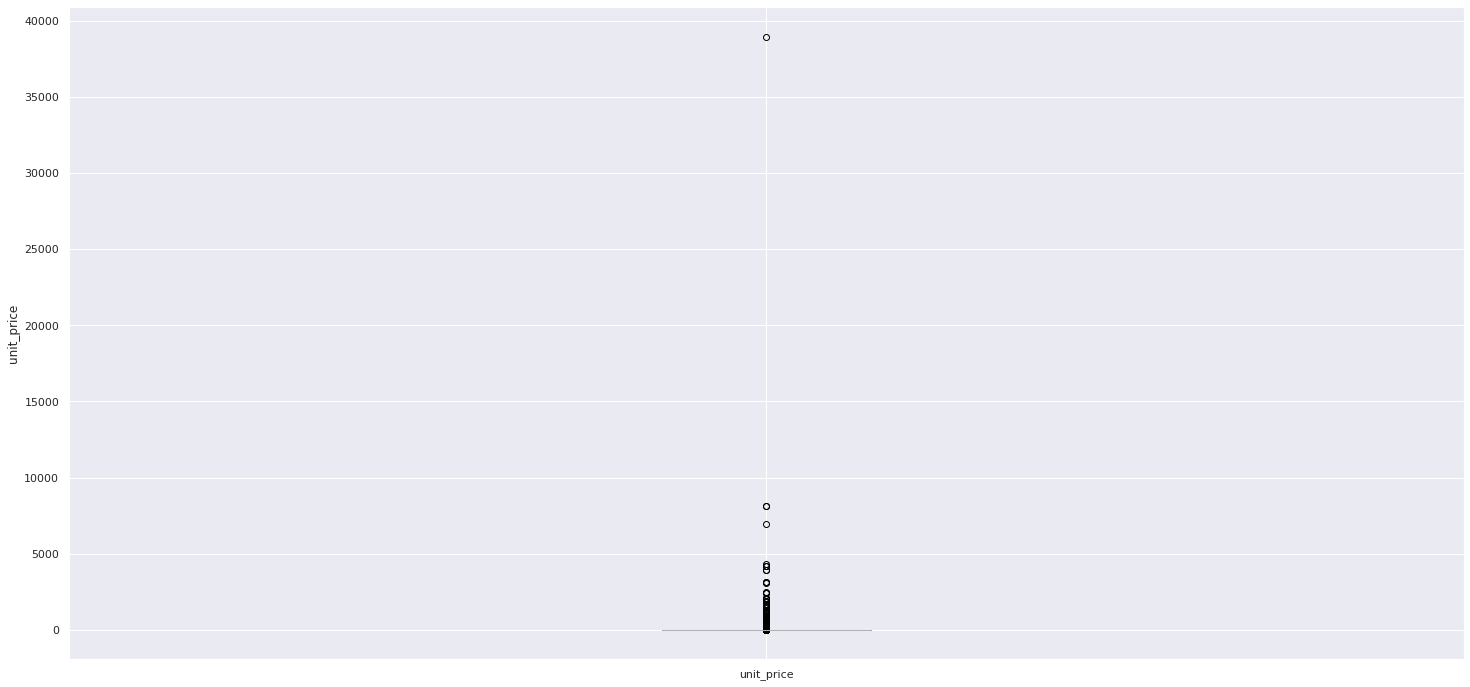

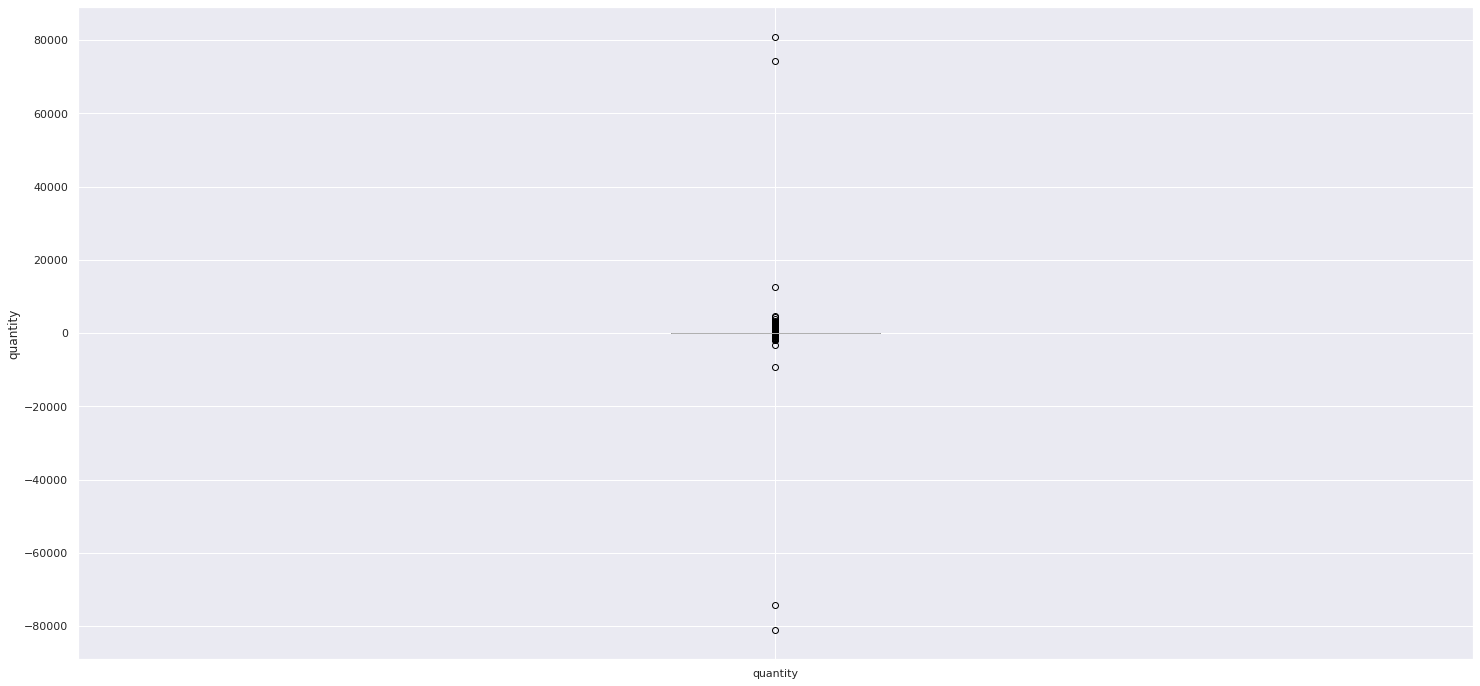

In [203]:
def find_outliers(df, var):
    df = df.copy()

    df.boxplot(column=var)
    plt.ylabel(var)
    plt.show()
        
for var in ['unit_price', 'quantity']:
    find_outliers(df1, var)

~~~
Let's remove the extreme values
~~~

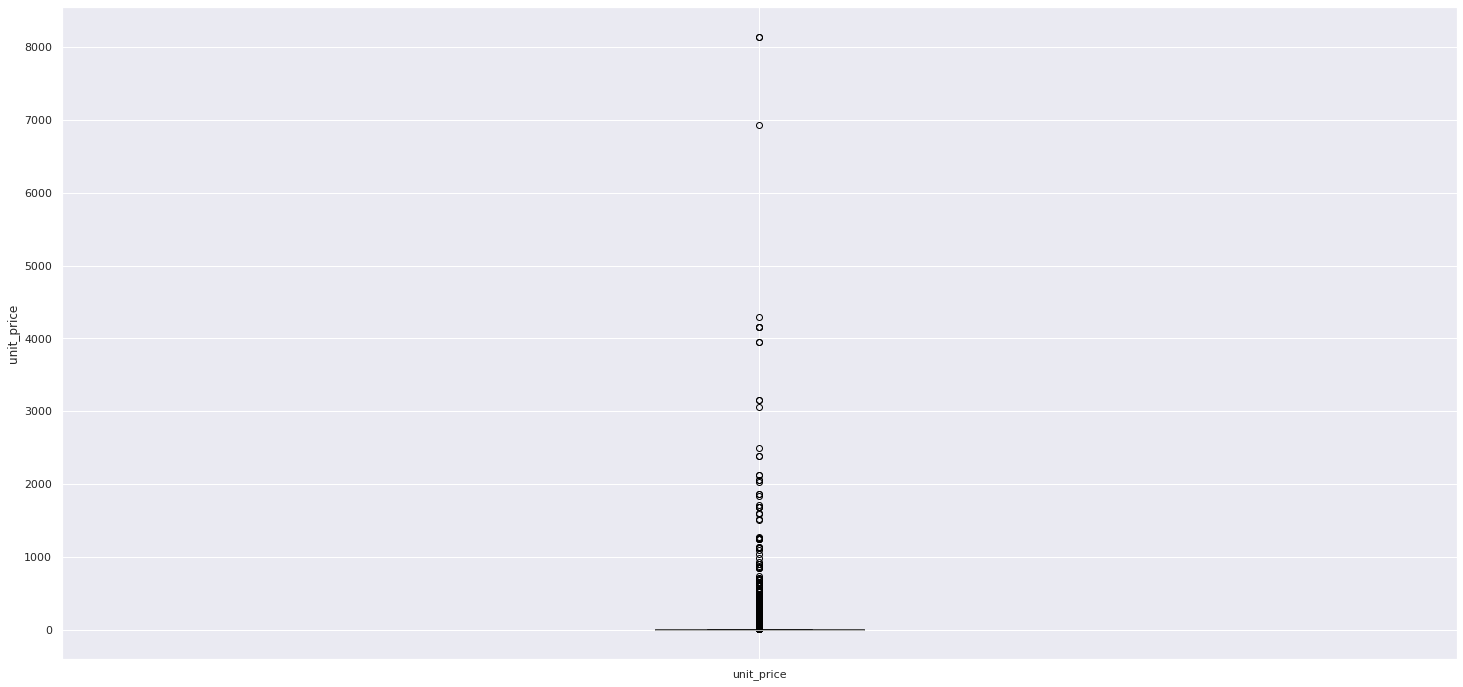

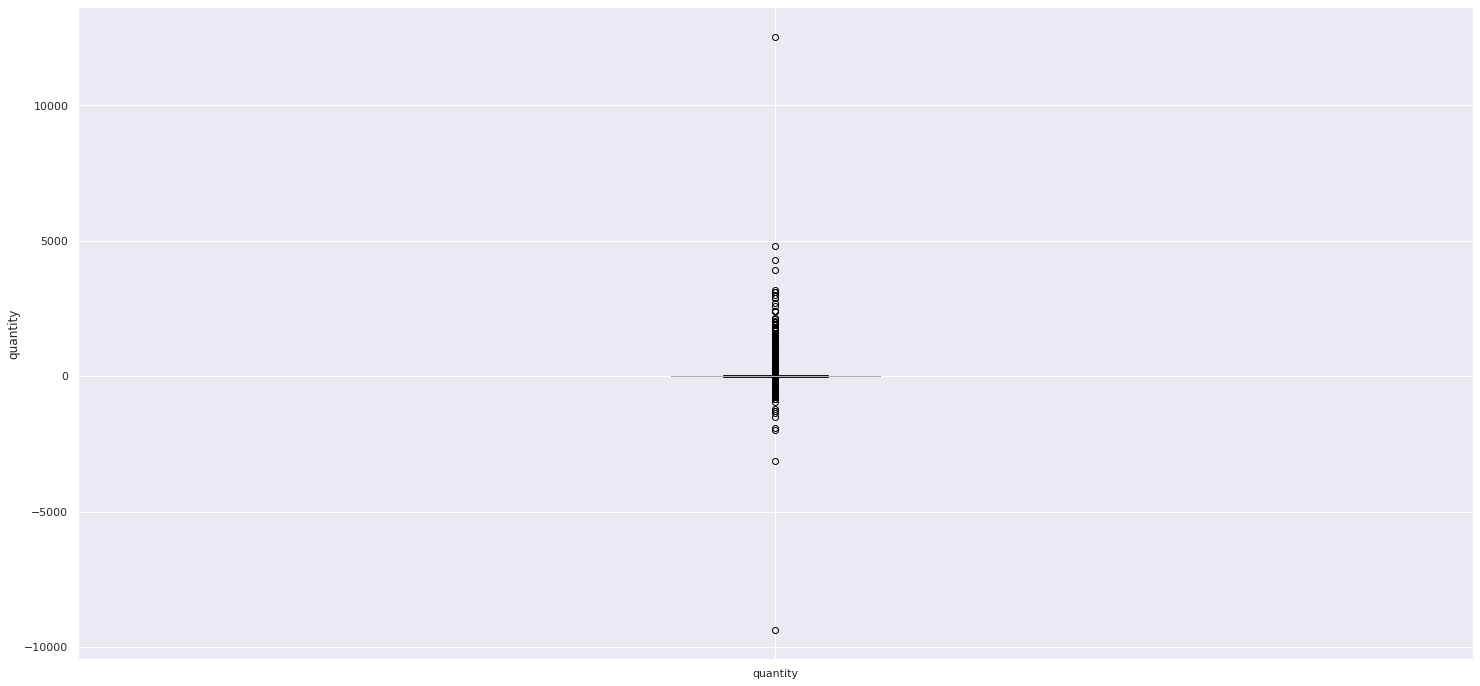

In [204]:
df1 = df1.query('quantity > -20000 and quantity < 20000')
df1 = df1.query('unit_price < 10000')

for var in ['unit_price', 'quantity']:
    find_outliers(df1, var)

# 2.0. Feature Engineering

In [205]:
df2 = df1.copy()

## 2.1. Feature Engineering

In [269]:
# year
df2['year'] = df2['invoice_date'].dt.year

# month
df2['month'] = df2['invoice_date'].dt.month

# day
df2['day'] = df2['invoice_date'].dt.day

# day of week
df2['day_of_week'] = df2['invoice_date'].dt.dayofweek

# UK holidays
uk_holidays = holidays.UnitedKingdom() 
df2['holidays_uk'] = df2['invoice_date'].apply(lambda x: x in uk_holidays)

# Revenue
df2['revenue'] = df2['quantity'] * df2['unit_price']

# 3.0. EDA

In [270]:
df3 = df2.copy()

## 3.1. General Questions and Some Hyphotesis

**Questions**
1. What are the top selling products?
2. What are the best months to sell?
3. Which countries have the most transactions?

**Hyphotesis**
4. On holiday sells more.
5. Sells more in the second semester of the year.
6. Sells less on weekends.
7. Sells more after the 10th of each month.

## 3.2. Questions

### 1. What are the top selling products?

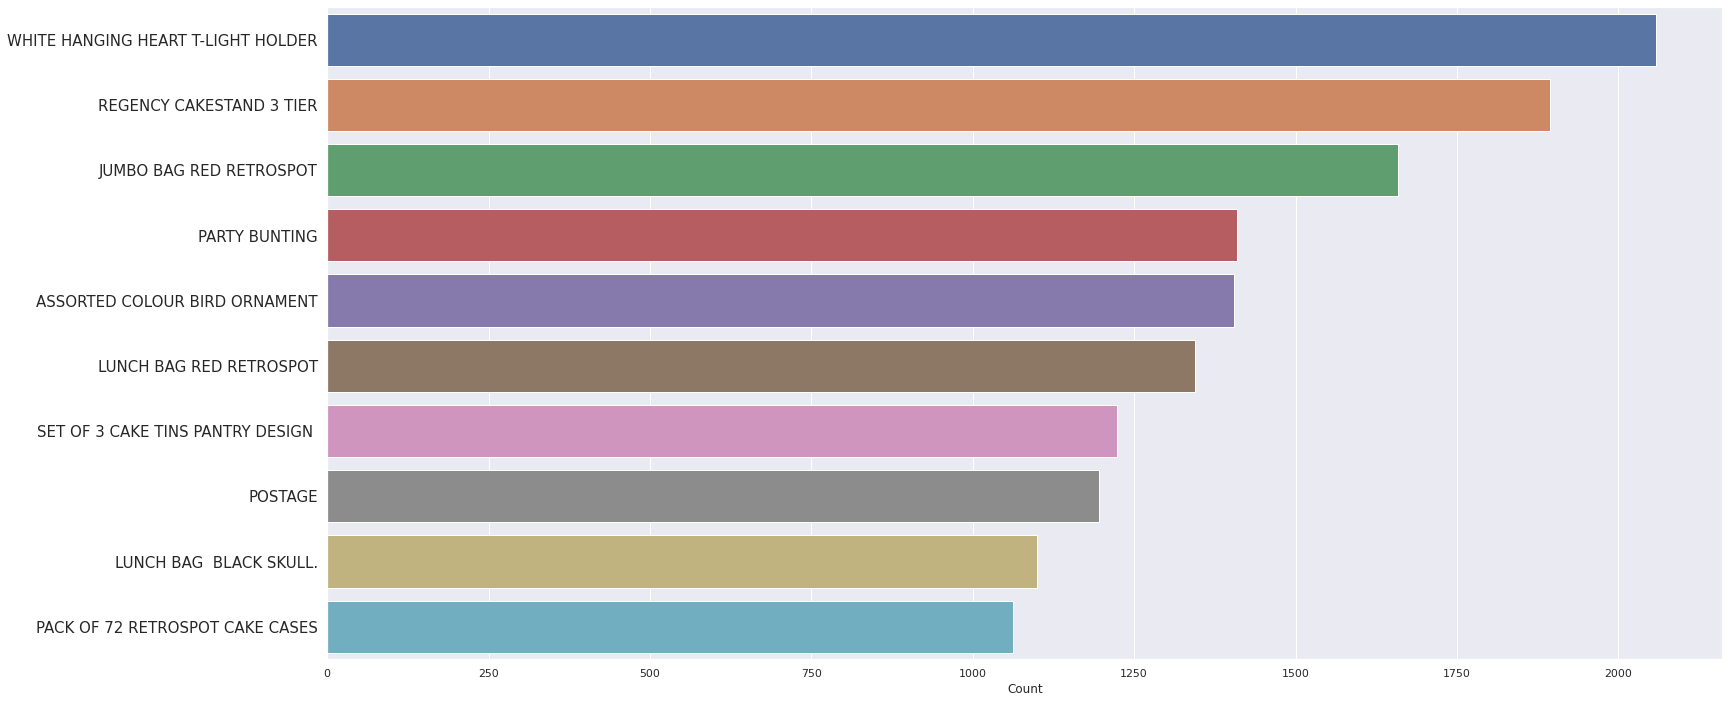

In [268]:
top_products = df3['description'].value_counts()[:10]
sns.barplot(y=top_products.index, x=top_products.values)
plt.xlabel('Count')
plt.yticks(fontsize=15);

### 2. What are the best months to sell?

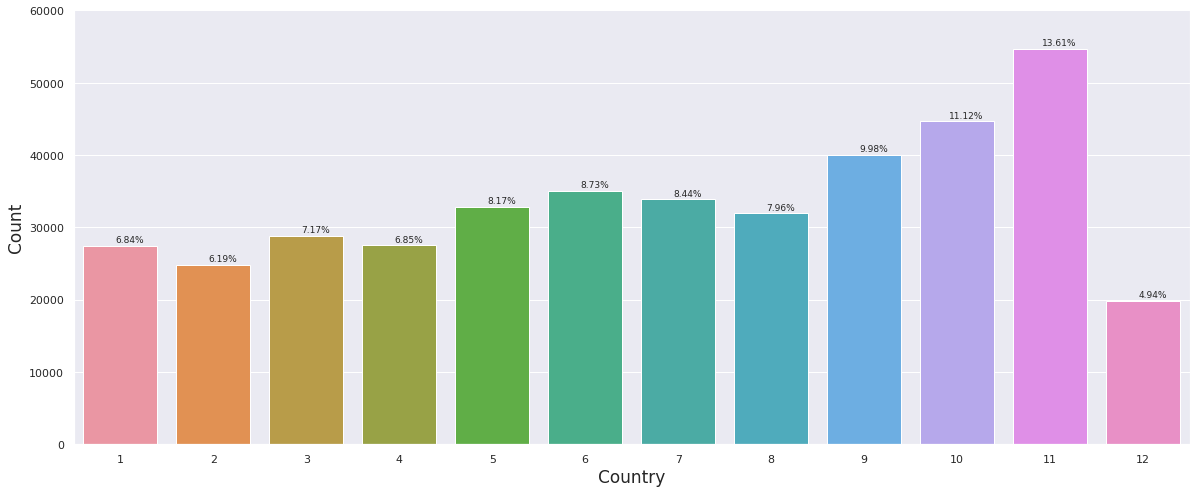

In [264]:
plot_perc('month', df3, order=False, rotation=False);

### 3. Which countries have the most transactions?

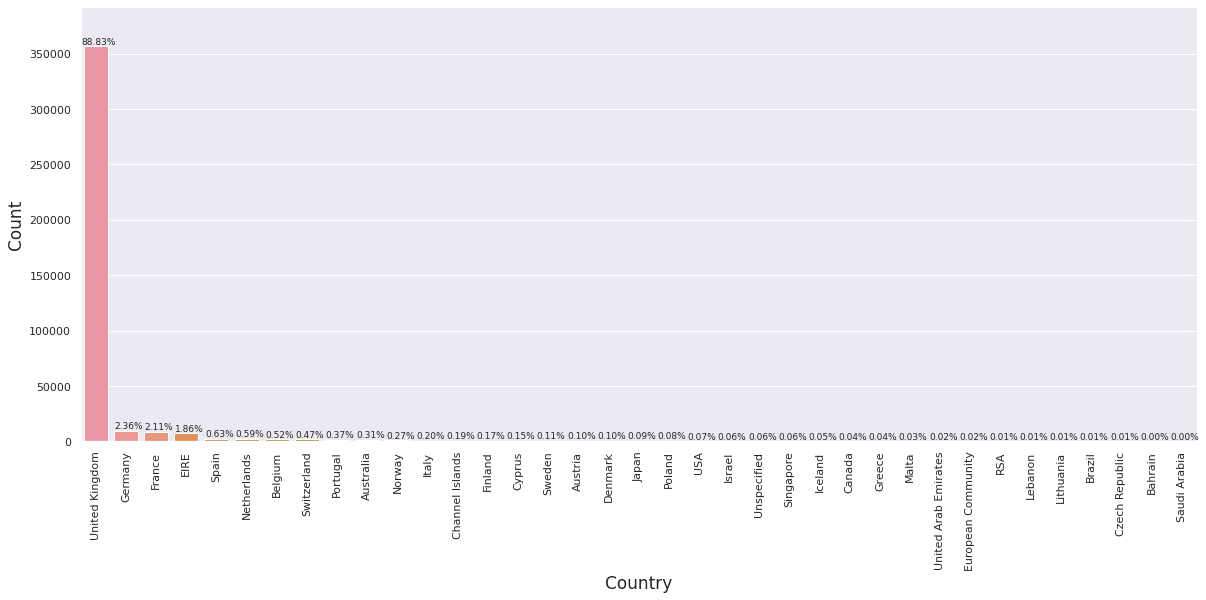

In [265]:
plot_perc('country', df3, order=True, rotation=True);

## 3.3. Hyphotesis

### 4. On holiday sells more.
**FALSE** None of the months does this phenomenon happen.

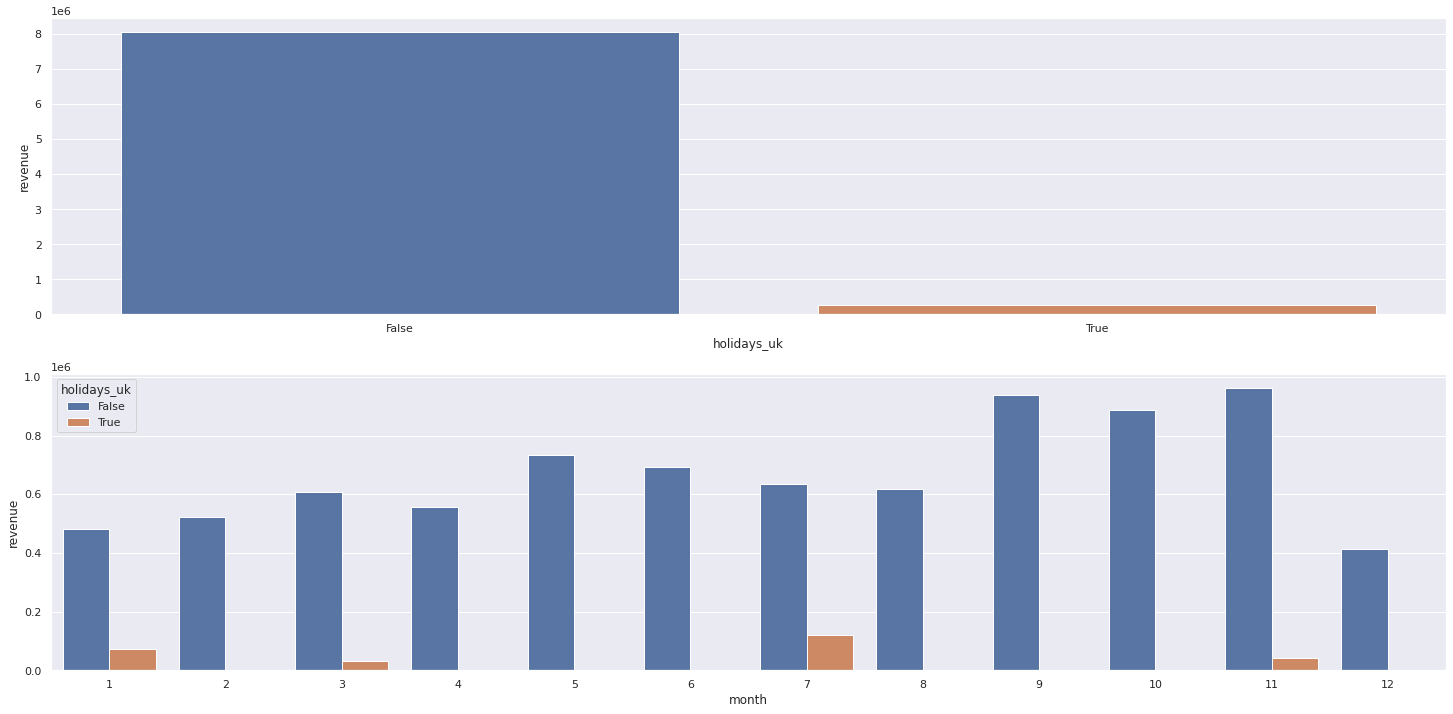

In [279]:
aux1 = df3[['holidays_uk', 'revenue']].groupby('holidays_uk').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x='holidays_uk', y='revenue', data=aux1);

aux2 = df3[['month', 'holidays_uk', 'revenue']].groupby(['month', 'holidays_uk']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x='month', y='revenue', hue='holidays_uk', data=aux2);

### 5. Sells more in the second semester of the year.
**TRUE** Seels more in the second semester of the year.

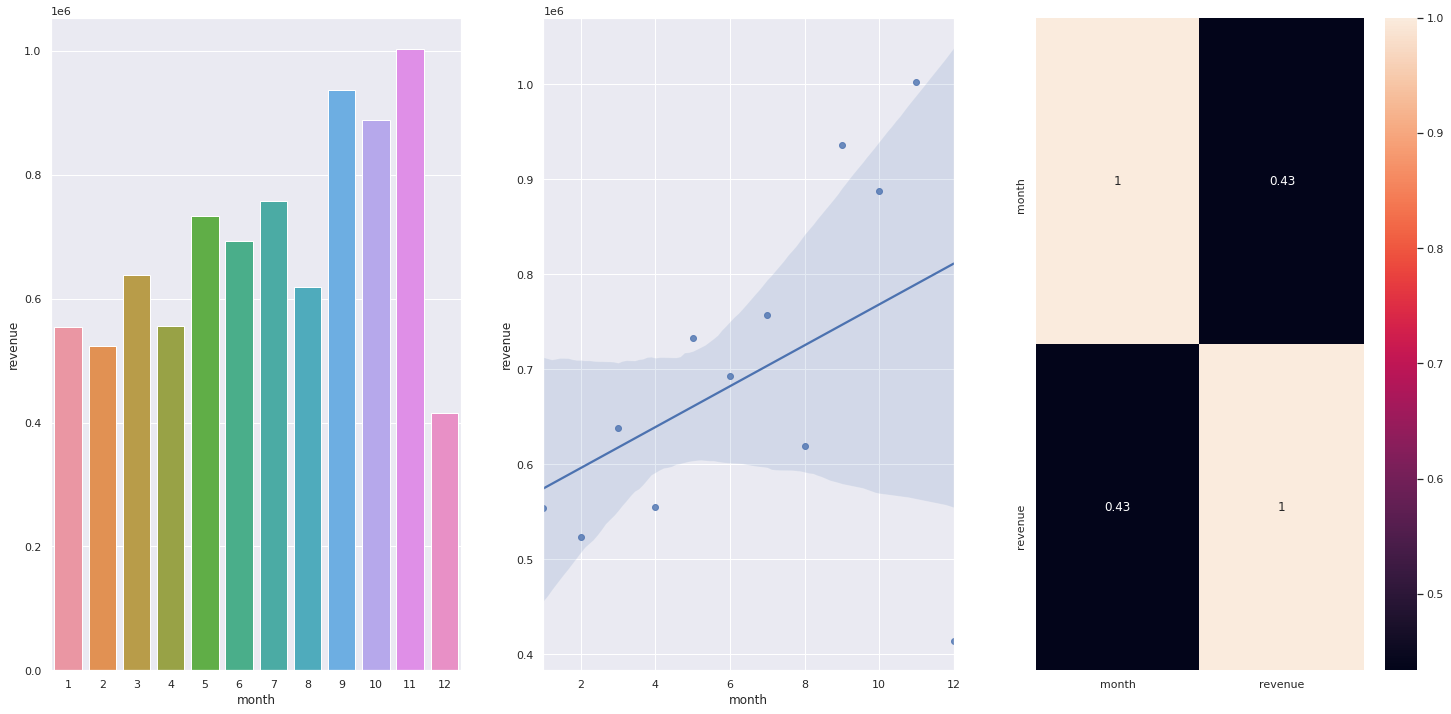

In [281]:
aux1 = df3[['month', 'revenue']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='month', y='revenue', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='revenue', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### 6. Sells less on weekends.
**TRUE** Sells less on weekends.

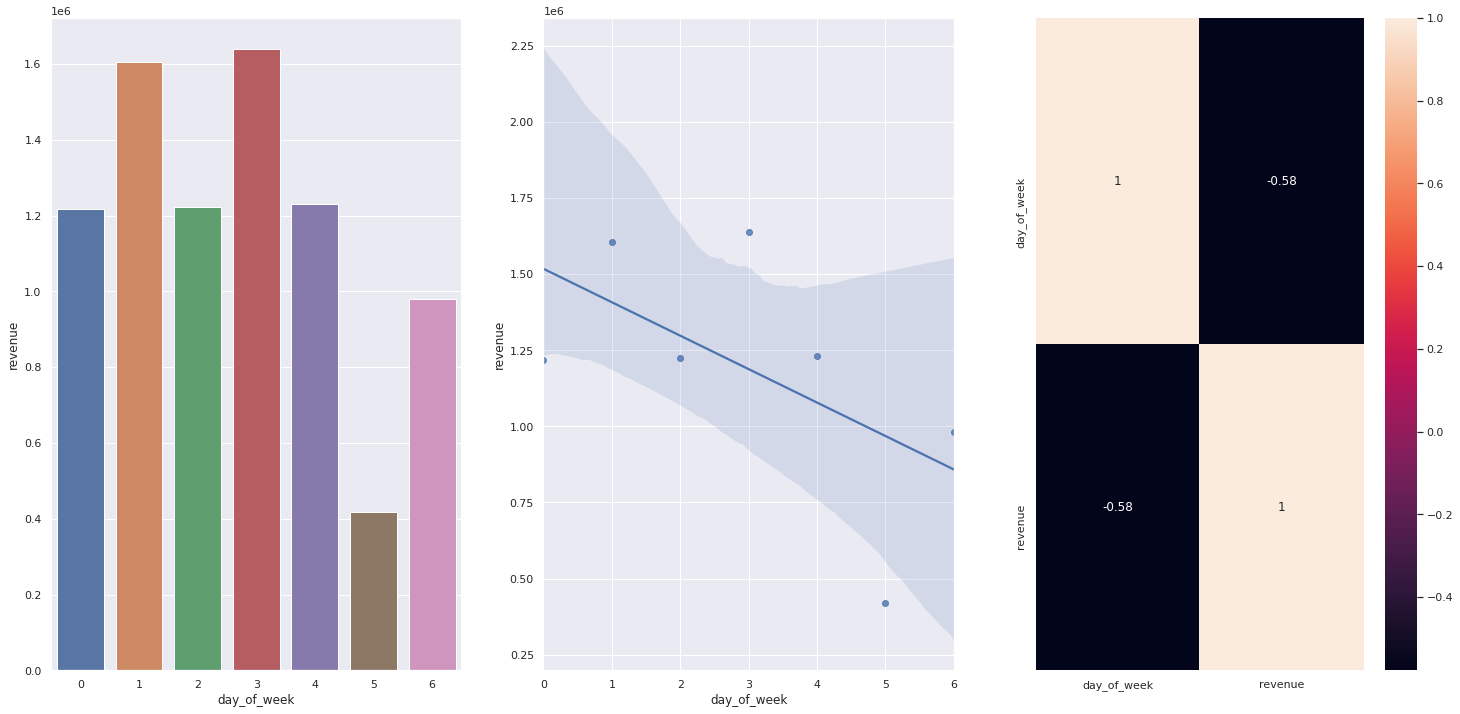

In [282]:
aux1 = df3[['day_of_week', 'revenue']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='revenue', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='revenue', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### 7. Sells more after the 10th of each month.
**True** Sells more after the 10th of each month.

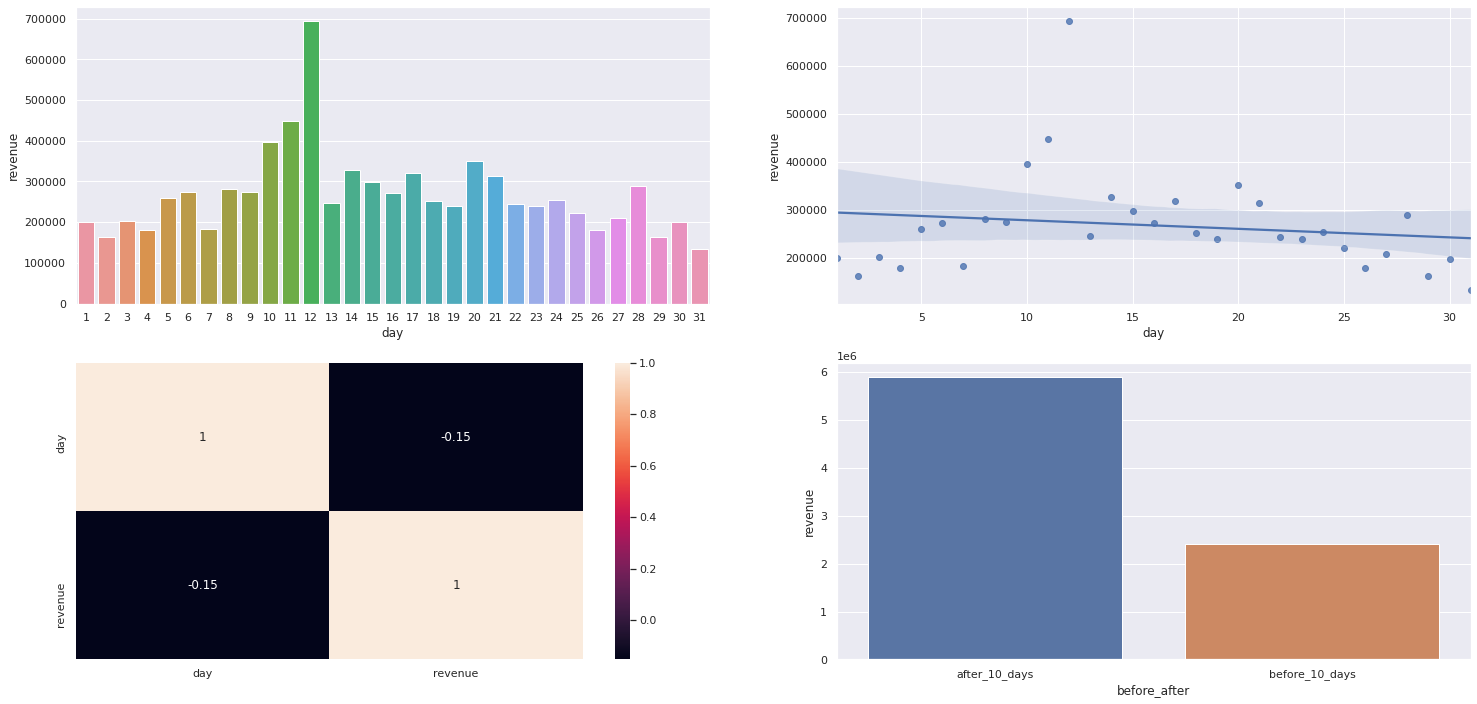

In [286]:
aux1 = df3[['day', 'revenue']].groupby('day').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x='day', y='revenue', data=aux1);

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='revenue', data=aux1);

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 = aux1[['before_after', 'revenue']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='revenue', data=aux2 );

# 4.0. Data Preparation

Let's prepare to our RFM analysis. This is a method used to analyze customer behavior and define market segments.

**R (Recency)**: How recently a customer made a purchase. It is an important predictor, as a customer who recently bought is more likely to buy again than one who bought a long time ago, in addition to being more likely to respond to promotions. 

**F (Frequency)**: How often a customer makes a purchase. If a customer buys frequently, he is expected to buy again.

**M (Monetary)**: How much money a customer spends on purchases. Those customers who spent a lot have more value for the organization compared to those who spent less

In [454]:
df4 = df3.copy()

## 4.1. Recency

In [455]:
df4['recency'] = df4['invoice_date'].max() - df4['invoice_date']

In [456]:
recency = df4[['customer_id', 'recency']].groupby('customer_id').min().reset_index()
recency['recency'] = recency['recency'].dt.days
recency.head()

,customer_id,recency
0,12347.0,40
1,12348.0,76
2,12349.0,19
3,12350.0,311
4,12352.0,73


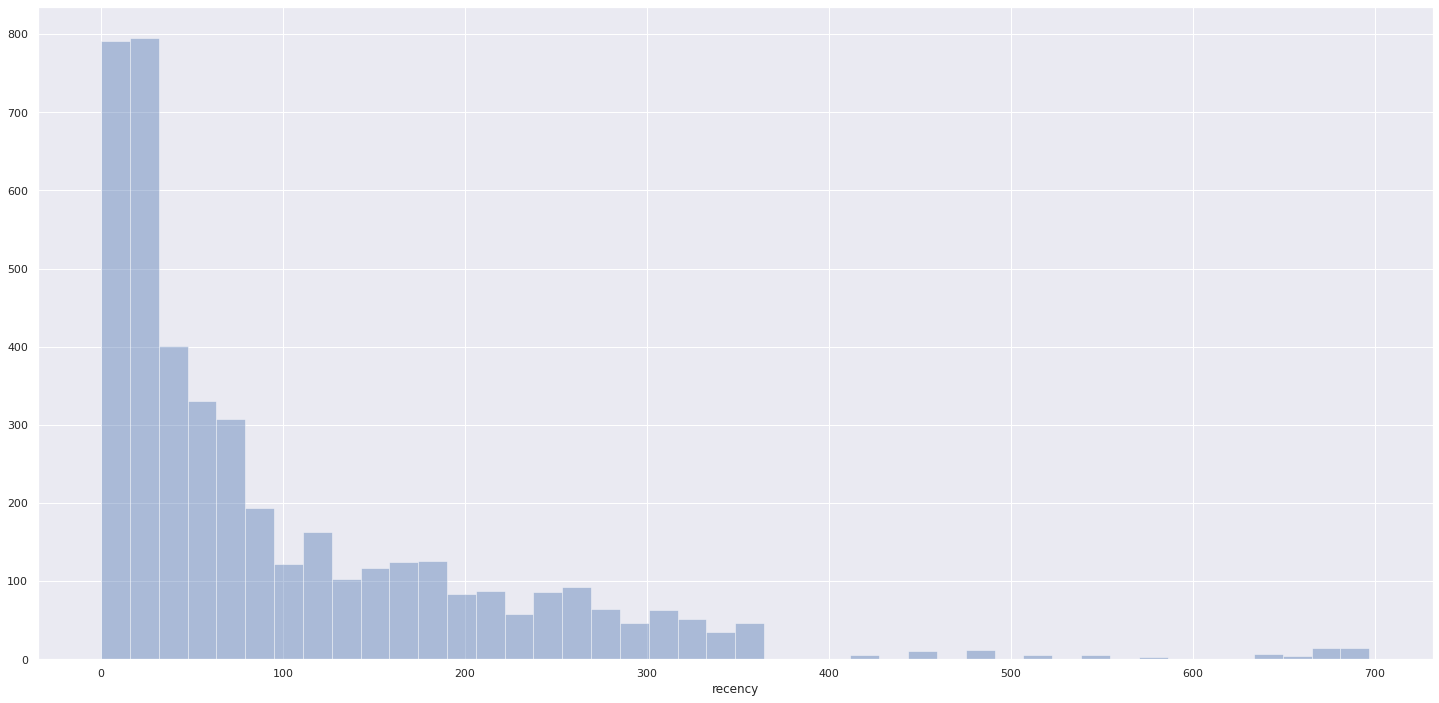

In [457]:
sns.distplot(recency['recency'], kde=False);

## 4.2. Frequency

In [458]:
frequency = df4[['customer_id', 'invoice_no']].groupby('customer_id').count().reset_index()
frequency.columns = ['customer_id', 'frequency']
frequency.head()

,customer_id,frequency
0,12347.0,182
1,12348.0,31
2,12349.0,73
3,12350.0,17
4,12352.0,95


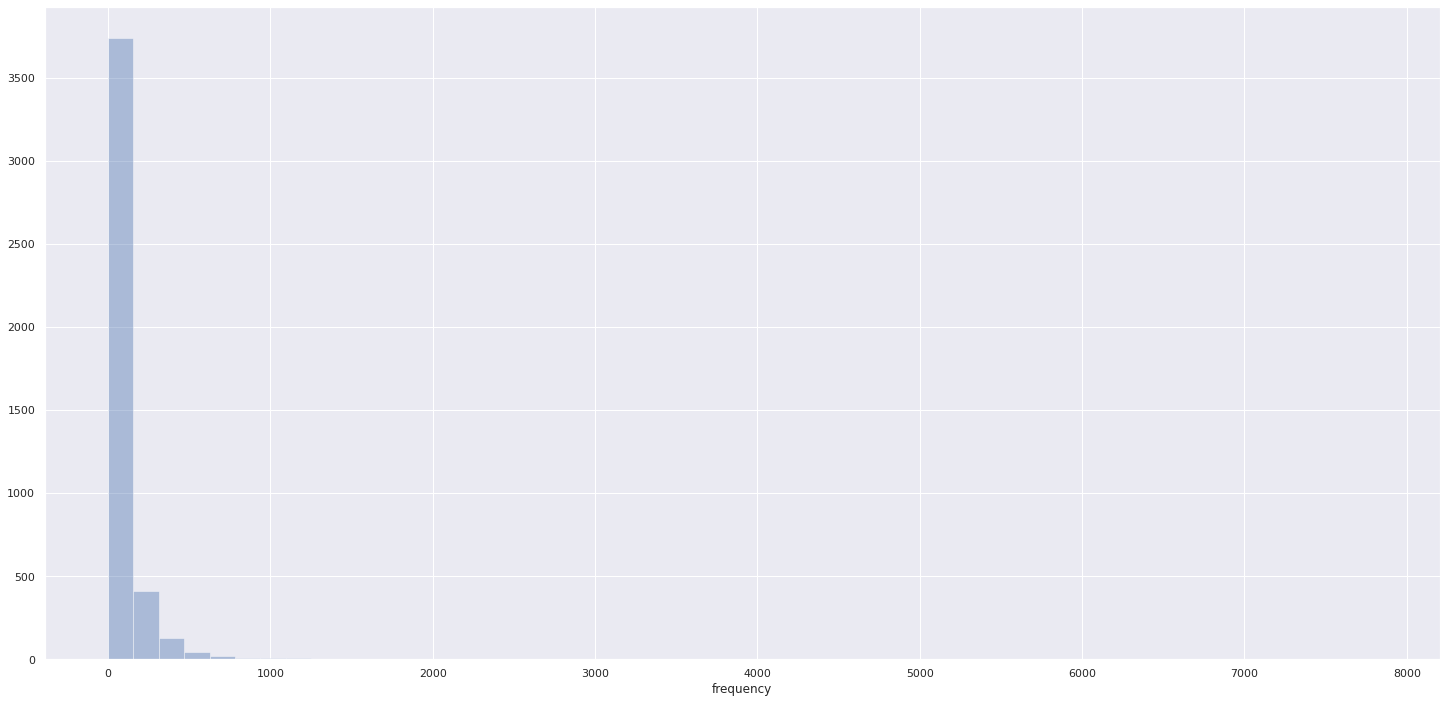

In [459]:
sns.distplot(frequency['frequency'], kde=False);

## 4.3. Monetary

In [460]:
monetary = df4[['customer_id', 'revenue']].groupby('customer_id').sum().reset_index()
monetary.columns = ['customer_id', 'monetary']
monetary.head()

,customer_id,monetary
0,12347.0,4310.00
1,12348.0,1797.24
2,12349.0,1757.55
3,12350.0,334.40
4,12352.0,1545.41


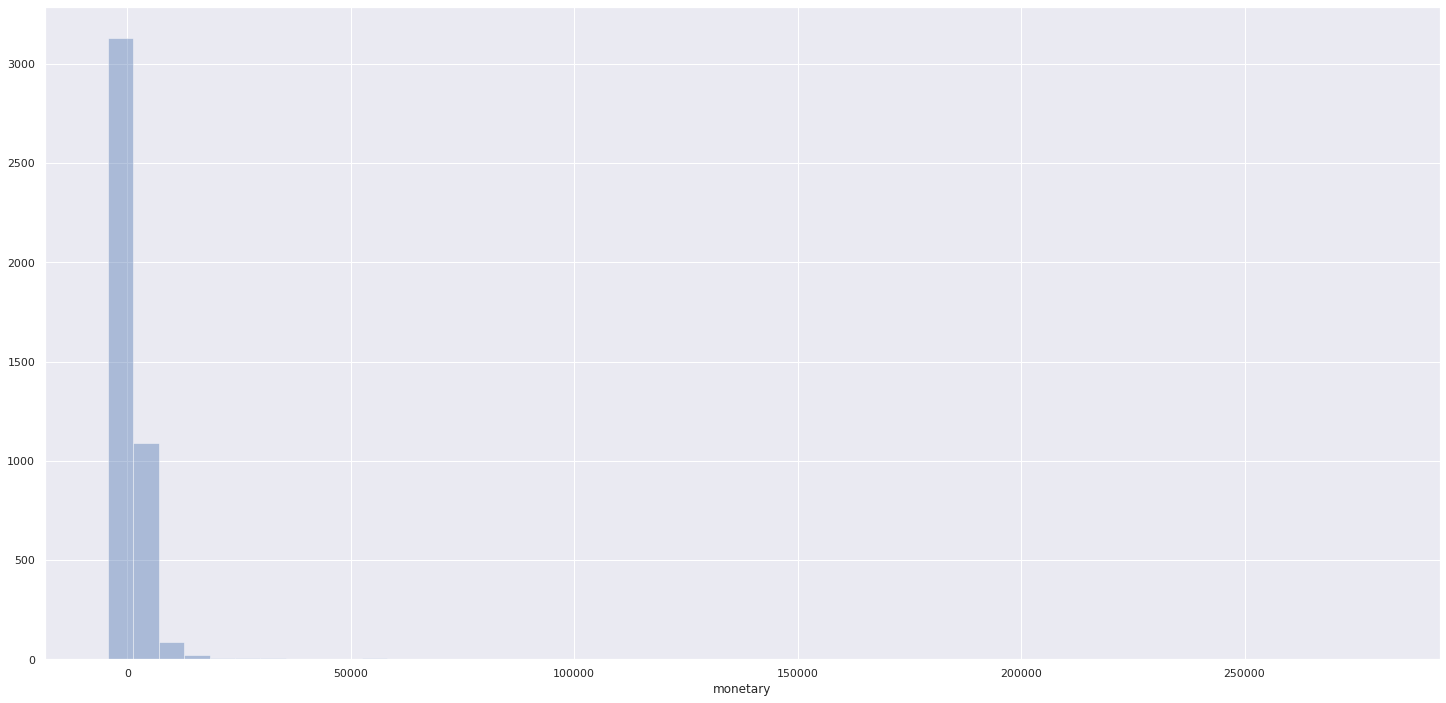

In [461]:
sns.distplot(monetary['monetary'], kde=False);

## 4.4. Merge the RFM

In [462]:
df_rfm = pd.merge(recency, frequency, on='customer_id', how='inner')
df_rfm = pd.merge(df_rfm, monetary, on='customer_id', how='inner')
df_rfm.head()

,customer_id,recency,frequency,monetary
0,12347.0,40,182,4310.00
1,12348.0,76,31,1797.24
2,12349.0,19,73,1757.55
3,12350.0,311,17,334.40
4,12352.0,73,95,1545.41


# 5.0. Machine Learning Model

In this challenger I will use the K-Means algorithm.

We use K-Means to assign a score to each RFM information and at the end we will combine it to create a final score.

In [463]:
df5 = df_rfm.copy()

## 5.1. Find the Optimal Number of Cluster

In [464]:
recency_data = df5[['recency']]

### 5.1.1. Elbow Method

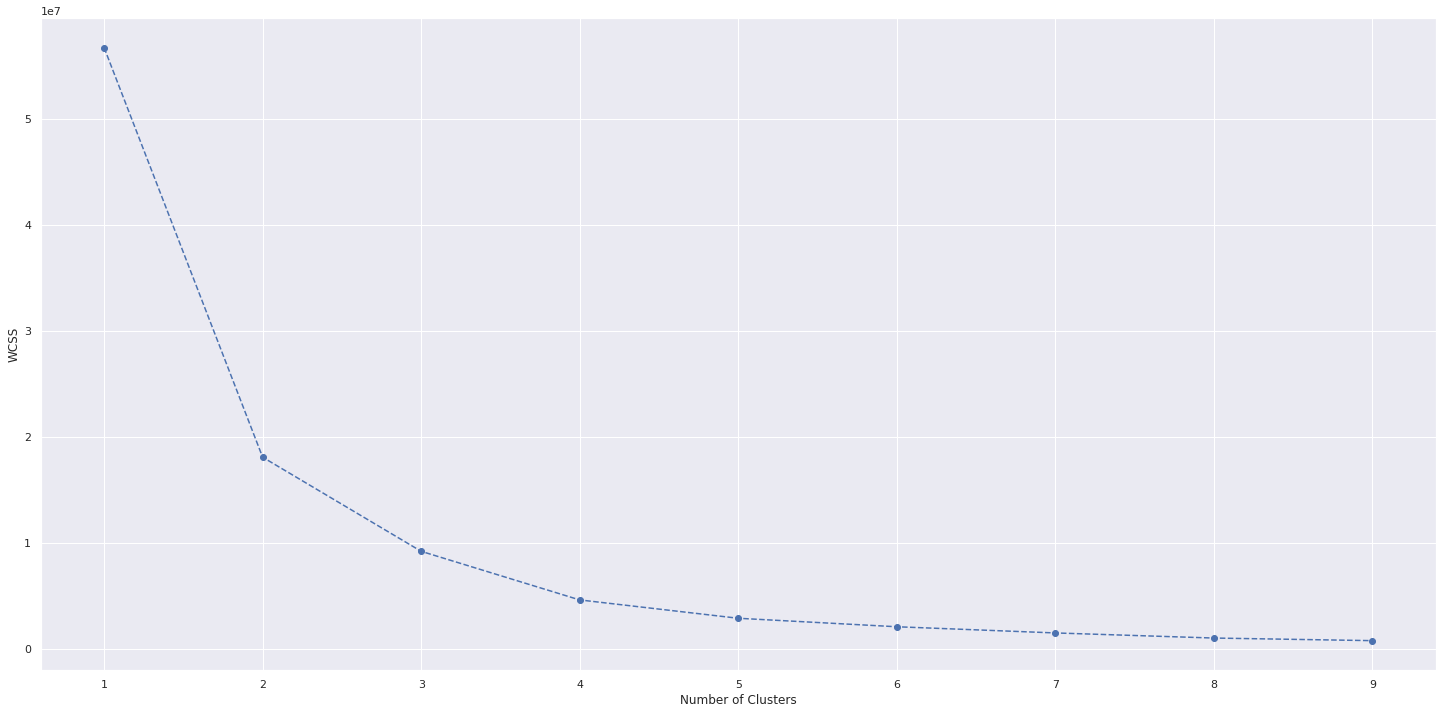

In [465]:
wcss = calculate_wcss(recency_data)

# plotting wcss against the number of clusters
plt.plot(range(1,10), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS');

~~~
Not sure if is 2, 3, 4 or 5...
Let's try a mathematical approach.
~~~

### 5.1.2. Mathematical Method

Ref: https://jtemporal.com/kmeans-and-elbow-method/

In [466]:
# calculating the sum of squares for the number of clusters
soma_quadrados = calculate_wcss(recency_data)

# calculating the optimal number of clusters
n = calculate_optimal_cluster(soma_quadrados)
n

5

~~~
5 is the optimal number of clusters!
Now we can calculate the scores of each RFM based on the best number of clusters.
~~~

## 5.2. Recency Score

In [469]:
kmeans = KMeans(n_clusters=5)

df5['recency_cluster'] = kmeans.fit_predict(recency_data)

df5 = order_cluster('recency_cluster', 'recency', df5, False)
df5.groupby('recency_cluster')['recency'].describe()

,count,mean,std,min,25%,50%,75%,max
recency_cluster,,,,,,,,
0,76.0,112.447368,107.864779,0.0,18.75,73.5,188.5,359.0
1,970.0,106.098969,121.472427,0.0,20.00,61.0,161.5,697.0
2,510.0,105.064706,116.682961,0.0,22.00,60.0,156.0,697.0
3,2176.0,98.784007,111.211280,0.0,20.00,53.0,146.5,697.0
4,639.0,95.674491,109.297359,0.0,22.00,54.0,142.0,697.0


## 5.3. Frequency Score

In [471]:
frequency_data = df5[['frequency']]

kmeans = KMeans(n_clusters=5)

df5['frequency_cluster'] = kmeans.fit_predict(frequency_data)

df5 = order_cluster('frequency_cluster', 'frequency', df5, True)
df5.groupby('frequency_cluster')['frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
frequency_cluster,,,,,,,,
0,3376.0,36.082938,28.204107,1.0,13.00,28.0,54.00,109.0
1,798.0,181.730576,59.891192,110.0,132.00,165.0,220.00,332.0
2,175.0,484.914286,137.065630,338.0,383.50,449.0,547.00,954.0
3,18.0,1478.055556,516.150283,1010.0,1118.25,1225.5,1660.25,2759.0
4,4.0,5824.250000,1449.742592,4459.0,4960.75,5513.0,6376.50,7812.0


## 5.4. Monetary Score

In [472]:
monetary_data = df5[['monetary']]

kmeans = KMeans(n_clusters=5)

df5['monetary_cluster'] = kmeans.fit_predict(monetary_data)

df5 = order_cluster('monetary_cluster', 'monetary', df5, True)
df5.groupby('monetary_cluster')['monetary'].describe()

,count,mean,std,min,25%,50%,75%,max
monetary_cluster,,,,,,,,
0,4065.0,939.198158,956.809152,-4287.63,270.6000,589.700,1298.0400,4437.23
1,271.0,8019.558376,3756.602295,4464.10,5312.0250,6676.760,9494.7300,21535.90
2,28.0,40913.384286,13160.882637,25748.35,28595.5500,35079.280,52855.3025,65892.08
3,5.0,128969.264000,36609.999351,88125.38,113214.5900,123725.450,132458.7300,187322.17
4,2.0,267963.755000,16299.186073,256438.49,262201.1225,267963.755,273726.3875,279489.02


In [473]:
df5.head()

,customer_id,recency,frequency,monetary,recency_cluster,frequency_cluster,monetary_cluster
0,12347.0,40,182,4310.00,3,1,0
1,12395.0,5,159,2998.28,3,1,0
2,12417.0,40,198,3578.80,3,1,0
3,12449.0,23,191,4067.29,3,1,0
4,12456.0,45,129,3153.89,3,1,0


## 5.5. Final Score

In [474]:
df5['final_score'] = df5['recency_cluster'] + df5['frequency_cluster'] + df5['monetary_cluster']
df5.groupby('final_score')['recency', 'frequency', 'monetary'].mean()

,recency,frequency,monetary
final_score,,,
0,132.426230,39.819672,650.997869
1,126.100402,36.088353,686.396120
2,104.550909,75.932727,1207.216582
3,111.869248,48.690797,890.457425
4,81.024691,107.815937,1896.754580
5,34.610329,259.910798,5508.742300
6,20.955556,416.733333,8852.790111
7,20.636364,1012.272727,18081.581364
8,6.700000,1764.000000,101555.710000


# 6.0. Interpretation

In [526]:
df6 = df5.copy()
df6.head()

,customer_id,recency,frequency,monetary,recency_cluster,frequency_cluster,monetary_cluster,final_score
0,12347.0,40,182,4310.00,3,1,0,4
1,12395.0,5,159,2998.28,3,1,0,4
2,12417.0,40,198,3578.80,3,1,0,4
3,12449.0,23,191,4067.29,3,1,0,4
4,12456.0,45,129,3153.89,3,1,0,4


## 6.1. Create Segments based on the Final Score

In [563]:
df6['segment'] = 'Inactive'

df6.loc[df6['final_score']>=2,'segment'] = 'Business' 
df6.loc[df6['final_score']>=4,'segment'] = 'Master' 
df6.loc[df6['final_score']>=6,'segment'] = 'Premium'
df6.loc[df6['final_score']>=8,'segment'] = 'VIP' 

df6.to_csv('data/rfm.csv', index=False)

## 6.2. Visualize Segments

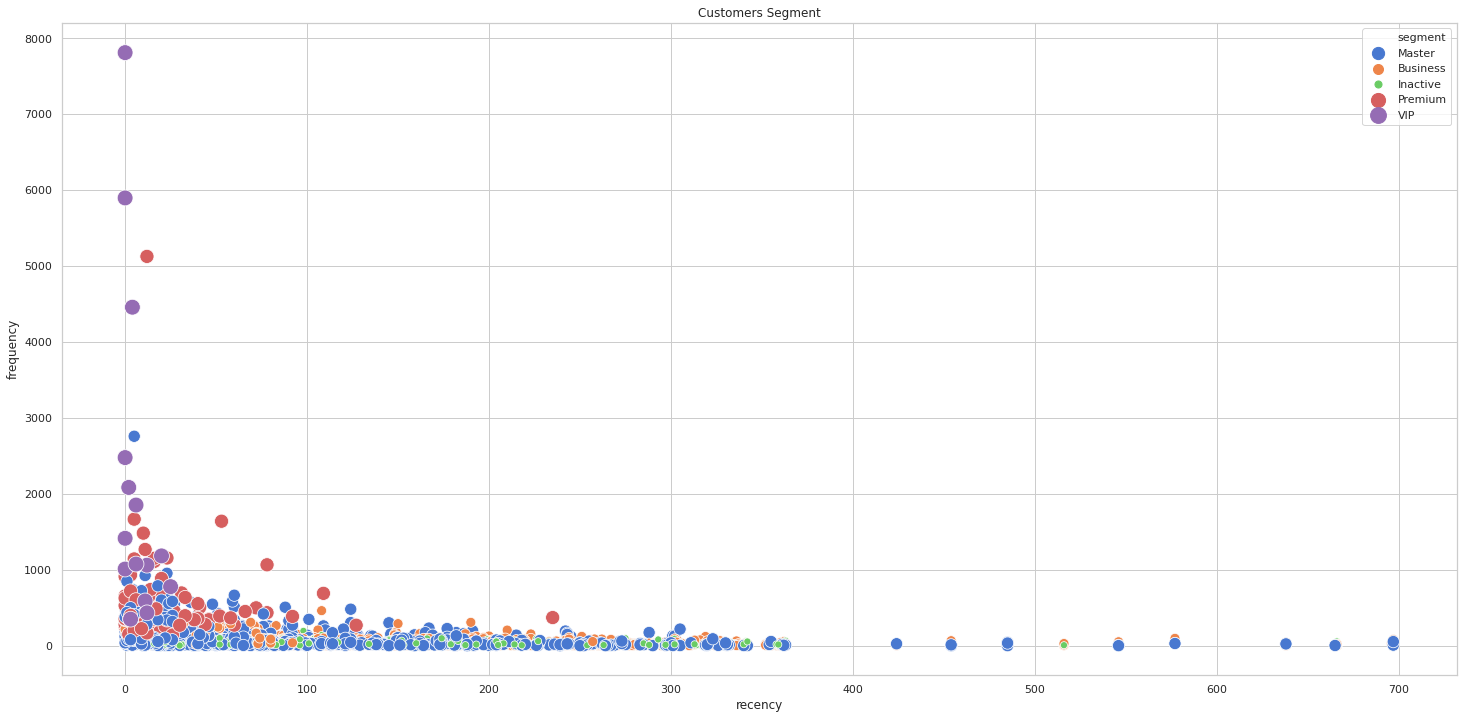

In [550]:
plot_segment('recency','frequency', df6)

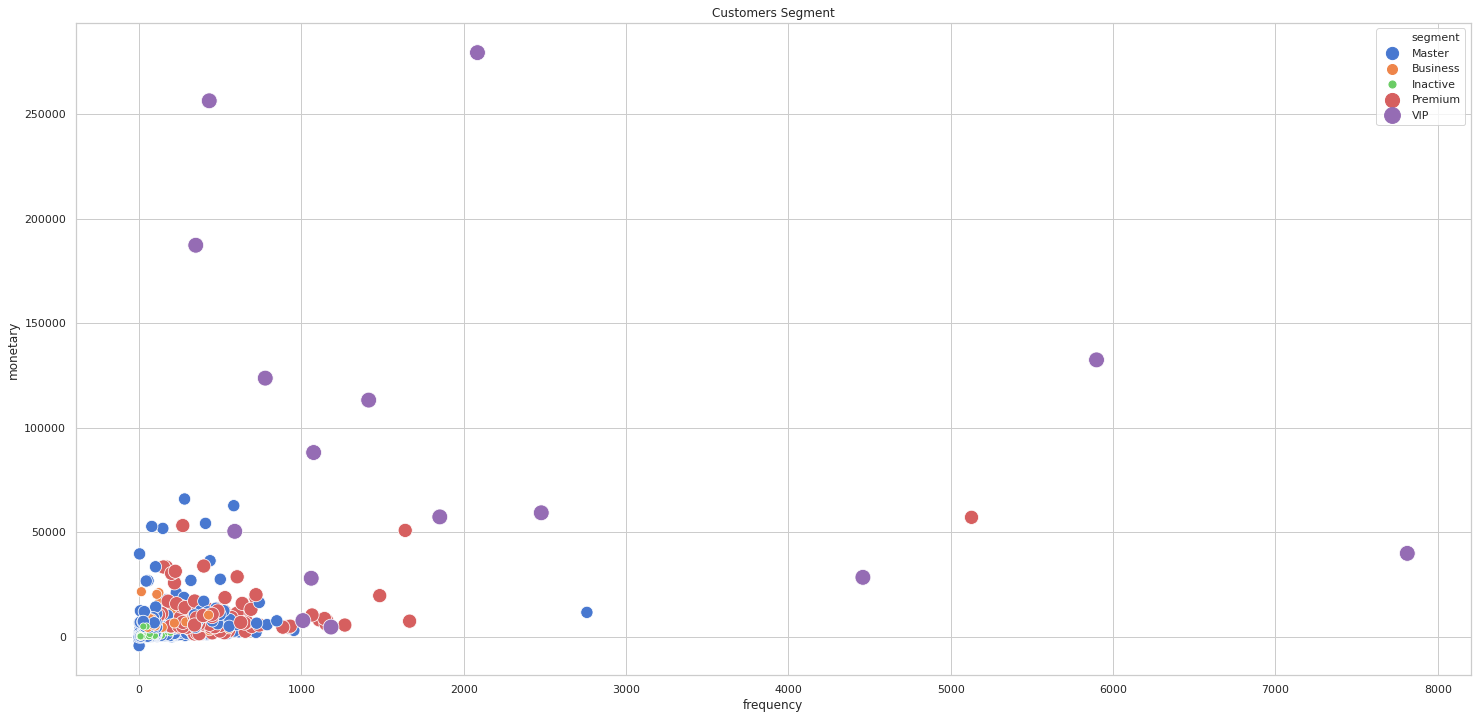

In [552]:
plot_segment('frequency', 'monetary', df6)

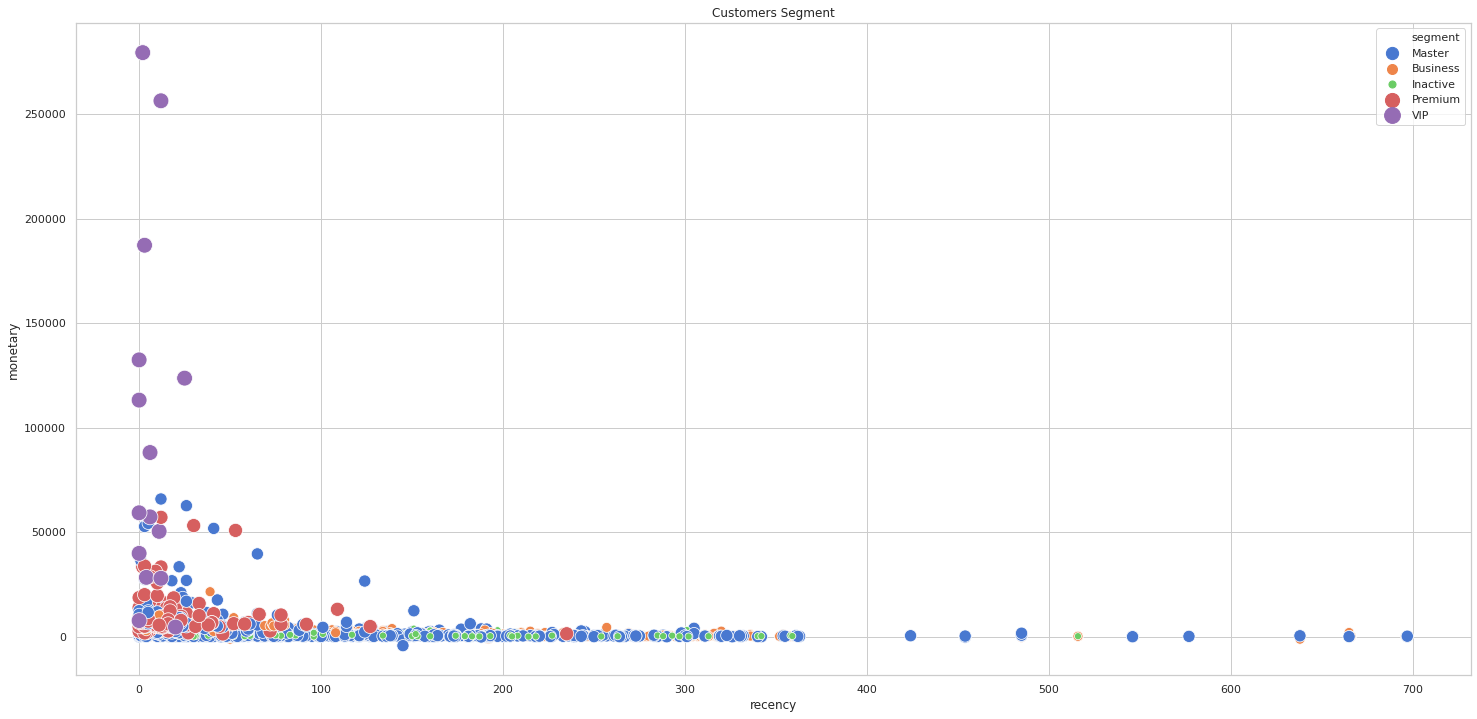

In [553]:
plot_segment('recency', 'monetary', df6)

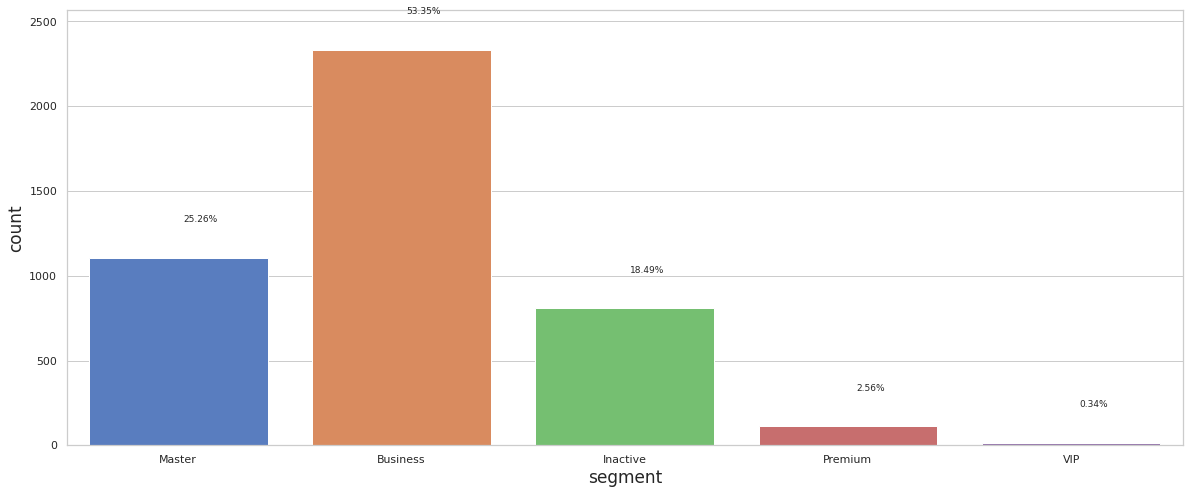

In [558]:
plot_perc('segment', df6)

# 7.0 Deployment

## 7.1. API

In [565]:
# from fastapi import FastAPI
# from pydantic import BaseModel

# app = FastAPI()

# class TextSample(BaseModel):
#     text: str

# class RequestBody(BaseModel):
#     samples: list[Sample]
        
#     def to_array(self):
#         return [sample.text for sample in self.samples]

# @app.get("/ping")
# async def pong():
#     return {"ping": "pong"}

# @app.post("/predict")#, response_model=SegmentOut, status_code=200)
# def get_prediction(body: RequestBody):
#     data = np.array(body.to_array())
    
#     return {
#         "customer_id": data[0]
#     }

NameError: name 'List' is not defined

## 7.2. API Tester

In [897]:
df7 = pd.read_csv('data/rfm.csv')
df7.head()

,customer_id,recency,frequency,monetary,recency_cluster,frequency_cluster,monetary_cluster,final_score,segment
0,12347.0,40,182,4310.00,3,1,0,4,Master
1,12395.0,5,159,2998.28,3,1,0,4,Master
2,12417.0,40,198,3578.80,3,1,0,4,Master
3,12449.0,23,191,4067.29,3,1,0,4,Master
4,12456.0,45,129,3153.89,3,1,0,4,Master


In [898]:
# choose customer_id
df_test = df7[df7['customer_id'].isin( [12347, 12395, 12417] )]
data = df_test.to_dict( orient='records' )
data

[{'customer_id': 12347.0,
  'recency': 40,
  'frequency': 182,
  'monetary': 4309.999999999997,
  'recency_cluster': 3,
  'frequency_cluster': 1,
  'monetary_cluster': 0,
  'final_score': 4,
  'segment': 'Master'},
 {'customer_id': 12395.0,
  'recency': 5,
  'frequency': 159,
  'monetary': 2998.279999999999,
  'recency_cluster': 3,
  'frequency_cluster': 1,
  'monetary_cluster': 0,
  'final_score': 4,
  'segment': 'Master'},
 {'customer_id': 12417.0,
  'recency': 40,
  'frequency': 198,
  'monetary': 3578.8,
  'recency_cluster': 3,
  'frequency_cluster': 1,
  'monetary_cluster': 0,
  'final_score': 4,
  'segment': 'Master'}]

In [923]:
# One unique value
data = {"customer_id": [12347]}

url = 'http://127.0.0.1:8000/ids'
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, json=data)    # , headers=header
print('Status Code {}'.format(r.status_code))
r.json()

Status Code 200


{'customer_id': 12347.0, 'segment': 'Master'}

In [921]:
# List of values
data = {"customer_id": [12347, 12395, 12417]}

url = 'http://127.0.0.1:8000/ids'
data = data

r = requests.post(url, json=data)    # , headers=header
print('Status Code {}'.format(r.status_code))
r.json()

Status Code 200


{'customer_id': [12347.0, 12395.0, 12417.0],
 'segment': ['Master', 'Master', 'Master']}